In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

print(tf.__version__)

2.3.0


In [2]:
ds_train, info = tfds.load('mnist', split='train[:100%]', shuffle_files=True, data_dir='/data', as_supervised=True, with_info=True)
ds_test = tfds.load('mnist', split='test[:10%]', shuffle_files=True, data_dir='/data', as_supervised=True)
print(info)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /data/mnist/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [5]:
def ds_to_numpy(ds):
    ds = tfds.as_numpy(ds)
    ds_list = list(ds)
    x, y = [], []
    for element_x, element_y in ds_list:
        x.append(element_x)
        y.append(element_y)
    return np.stack(x), np.stack(y)

x_train, y_train = ds_to_numpy(ds_train)
x_test, y_test = ds_to_numpy(ds_test)
x_train = (x_train - 127.5)/127.5
x_test = (x_test - 127.5)/127.5

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('max: ',x_train.max())
print('min ', x_train.min())

(60000, 28, 28, 1)
(60000,)
(1000, 28, 28, 1)
(1000,)
max:  1.0
min  -1.0


In [38]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, BatchNormalization, Dense, Input, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers
class GanModel():
    def __init__(self, image_shape, num_latent, x_train, batch_size=32):
        self.image_shape = image_shape
        self.num_latent = num_latent
        self.batch_size = batch_size
        self.x_train = np.random.permutation(x_train)
        self.gan = self.make_gan()
        self.d_opt = Adam(1e-4)
        self.g_opt = Adam(1e-4)
        self.loss = {'d':[] , 'g':[]}

    def make_descriminator(self):
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                        input_shape=[28, 28, 1]))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Flatten())
        model.add(layers.Dense(1))
        return model
    
    def make_generator(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Reshape((7, 7, 256)))
        assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

        model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        assert model.output_shape == (None, 7, 7, 128)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert model.output_shape == (None, 14, 14, 64)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        assert model.output_shape == (None, 28, 28, 1)

        return model

    def make_gan(self):
        self.descriminator = self.make_descriminator()
        self.generator = self.make_generator()
        input = Input(shape=(self.num_latent,))
        x = self.generator(input)
        x = self.descriminator(x)
        gan = Model(inputs=input, outputs=x)
        return gan
    
    def fit(self):
        def train_step():
            noise = np.random.normal(size=(self.batch_size, self.num_latent))
            real_samples = self.x_train[np.random.randint(0, self.x_train.shape[0], self.batch_size)]
            
            # train generator
            with tf.GradientTape() as gen_tape:
                gen_tape.watch(self.generator.trainable_variables)
                y_pred_generator = self.gan(noise, training=True)
                gen_loss = BinaryCrossentropy(from_logits=True)(np.ones((self.batch_size,1)), y_pred_generator)
                gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
                self.g_opt.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
                self.loss['g'].append(gen_loss.numpy())
            
            # train descriminator
            with tf.GradientTape() as disc_tape:
                disc_tape.watch(self.descriminator.trainable_variables)
                y_true_descriminator = np.zeros((self.batch_size*2, 1))
                y_true_descriminator[:self.batch_size] = 1.0
                generated_images = self.generator(noise, training=True)
                y_pred_descriminator = self.descriminator(np.concatenate([real_samples, generated_images], axis=0), training=True)
                disc_loss = BinaryCrossentropy(from_logits=True)(y_true_descriminator, y_pred_descriminator)
                gradients_of_discriminator = disc_tape.gradient(disc_loss, self.descriminator.trainable_variables)
                self.d_opt.apply_gradients(zip(gradients_of_discriminator, self.descriminator.trainable_variables))
                self.loss['d'].append(disc_loss.numpy())

        iterations_per_epoch = int((len(self.x_train))/self.batch_size)
        for iter in range(iterations_per_epoch):
            train_step()

model = GanModel(image_shape=(28, 28, 1), num_latent=100,x_train = x_train, batch_size= 256)

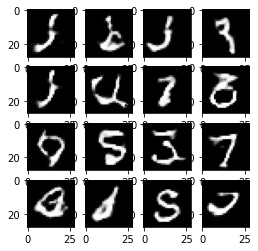

finish of the 49: in 18.29742932319641 s


In [39]:
fixed_noise = np.random.normal(size=(16,100)) #evaluation on fixed data
epochs = 50
print('here we go')
for num_epoch in range(epochs):
    t1 = time.time()
    model.fit()
    gan_out = model.generator.predict(fixed_noise)
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        fig.add_subplot(4,4,i+1)
        plt.imshow(gan_out[i, :, :,0], cmap='gray')
    plt.show()
    t2 = time.time()
    print(f'finish of the {num_epoch}: in {t2-t1} s')
    display.clear_output(wait=True)

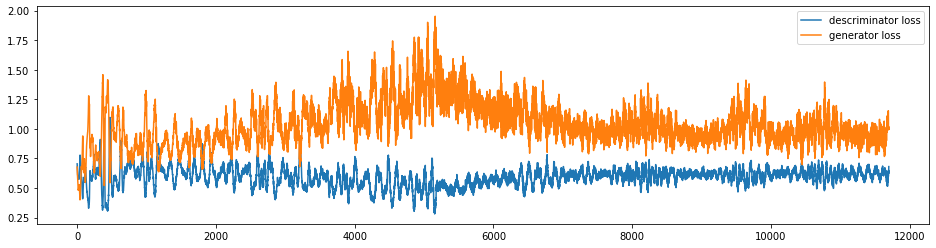

In [40]:
plt.figure(figsize=(16,4))
plt.plot(model.loss['d'], label='descriminator loss')
plt.plot(model.loss['g'], label='generator loss')
plt.legend()
plt.show()

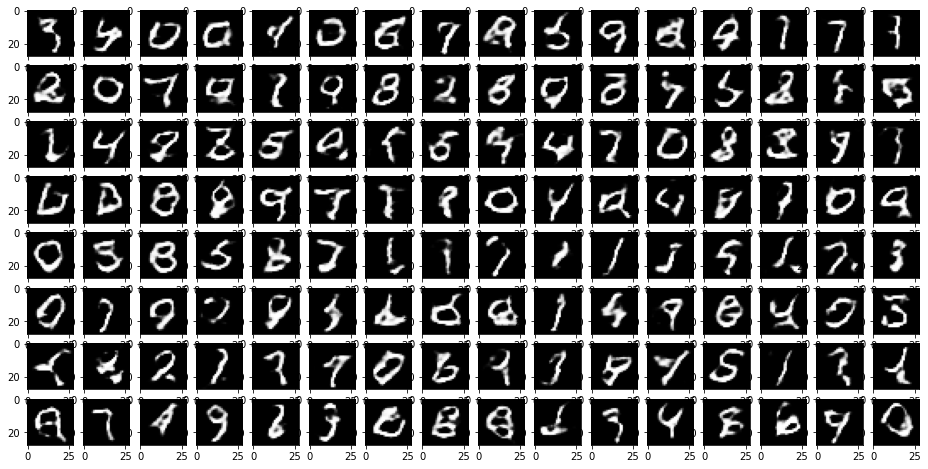

In [41]:
fixed_noise2 = np.random.normal(size=(16*8,100)) #evaluation on fixed data
#more samples
gan_out = model.generator.predict(fixed_noise2)
fig = plt.figure(figsize=(16,8))
for i in range(16*8):
    fig.add_subplot(8,16,i+1)
    plt.imshow(gan_out[i, :, :,0], cmap='gray')